In [2]:

import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm

In [3]:
!pip install roboflow supervision -q

In [4]:

import roboflow
import supervision as sv

In [5]:
cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd, "Soybean Leaf Dataset for Disease Classification")

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

In [6]:
labels

{'d:\\Soybean\\Soybean Leaf Dataset for Disease Classification\\Bacterial Pustule\\BP (1).jpg': 'Bacterial Pustule',
 'd:\\Soybean\\Soybean Leaf Dataset for Disease Classification\\Bacterial Pustule\\BP (10).jpg': 'Bacterial Pustule',
 'd:\\Soybean\\Soybean Leaf Dataset for Disease Classification\\Bacterial Pustule\\BP (11).jpg': 'Bacterial Pustule',
 'd:\\Soybean\\Soybean Leaf Dataset for Disease Classification\\Bacterial Pustule\\BP (12).jpg': 'Bacterial Pustule',
 'd:\\Soybean\\Soybean Leaf Dataset for Disease Classification\\Bacterial Pustule\\BP (13).jpg': 'Bacterial Pustule',
 'd:\\Soybean\\Soybean Leaf Dataset for Disease Classification\\Bacterial Pustule\\BP (14).jpg': 'Bacterial Pustule',
 'd:\\Soybean\\Soybean Leaf Dataset for Disease Classification\\Bacterial Pustule\\BP (15).jpg': 'Bacterial Pustule',
 'd:\\Soybean\\Soybean Leaf Dataset for Disease Classification\\Bacterial Pustule\\BP (16).jpg': 'Bacterial Pustule',
 'd:\\Soybean\\Soybean Leaf Dataset for Disease Classific

In [7]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

dinov2_vits14.to(device)

transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])
     

Using cache found in C:\Users\Sarth/.cache\torch\hub\facebookresearch_dinov2_main


In [8]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}
    
    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

In [9]:
embeddings = compute_embeddings(files)

  0%|          | 0/345 [00:00<?, ?it/s]

In [10]:
from sklearn import svm

clf = svm.SVC(gamma='scale')

y = [labels[file] for file in files]

embedding_list = list(embeddings.values())

clf.fit(np.array(embedding_list).reshape(-1, 384), y)

SVC()

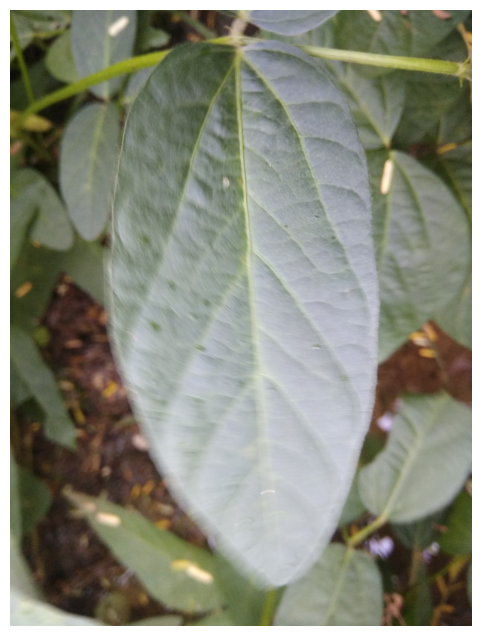


Predicted class: Healthy


In [11]:
input_file = "D:\Soybean\Soybean Leaf Dataset for Disease Classification\Healthy\Healthy (1).jpg"

new_image = load_image(input_file)

%matplotlib inline
sv.plot_image(image=cv2.imread(input_file), size=(8, 8))

with torch.no_grad():
    embedding = dinov2_vits14(new_image.to(device))

    prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print()
    print("Predicted class: " + prediction[0])